<h1><center><font size="6">Drawing classification with convolutional neural network</font></center></h1>

# 1.Introdocution
We use the [dataset](https://quickdraw.withgoogle.com/data) provided by google to train a convolutional neural network for multi-classification task. The dataset we use is an image dataset that consists of drawings from people all over the world playing [Quick, Draw!](https://quickdraw.withgoogle.com/). The dataset used in this project contains 10 categories, that is, 1.5 million drawings in total.

# 2.Import  packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.metrics import top_k_categorical_accuracy,sparse_top_k_categorical_accuracy
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.utils import plot_model
%matplotlib inline 

Using TensorFlow backend.


## 3. Load data


Set parameters used

In [2]:
RANDOM_STATE = 2019  # for reduplicating the result
DATA_PATH = '../data/'
IMG_SIZE = 28
K = 5 # how many folds for performing cross validation

The [data](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap) downloaded are numpy arrays. One array contains one category. First we load all 9 categories, and then merge them into one, meanwhile, we extract the label from the filename.

In [3]:
cate_dict = {}
cate_amount = []
for i, f in enumerate(os.listdir(DATA_PATH)):
    if f.split('.')[-1] == 'npy':
        print('processing {}...'.format(f.split('.')[0]))
        arr = np.load(DATA_PATH + f)
        cate_dict[f.split('.')[0]] = i
        cate_amount.append(arr.shape[0])
        cate_label = np.repeat(i, arr.shape[0])
        if i == 0:
            data = arr
            label = cate_label
        else:
            data = np.concatenate((data, arr)) # merge all into one
            label = np.concatenate((label, cate_label)) # merge all label into one array
cate_index = np.insert(np.cumsum(cate_amount), 0, 0)[:-1]
NUM_CLASSES = len(cate_dict)
print('{} drawings in total'.format(sum(cate_amount)))

processing axe...
processing banana...
processing bench...
processing hexagon...
processing knife...
processing line...
processing pencil...
processing skull...
processing triangle...
1390738 drawings in total


## 4. Data exploration

The original image data is a vector that contains 784 elements representing the gray scale value. 0 in gray scale value represents totally black, 255 represents totaly white. In order to feed it into the convolution network, we resize it to 28 x 28, a 2d image.

In [4]:
print('The shape of the original data is {}'.format(data[0].shape))
print('An example of the original image data:\n\n{}'.format(data[0]))

The shape of the original data is (784,)
An example of the original image data:

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  30  92  13   0   0   0   0   0   0
   0   0   0   0   0   0   0  61 110  22   0   0   0   0   0   0   0   0
   0 205 255 255 159   0   0   0   0   0   0   0   0   0   0   0   0 174
 254 249 172  76  15   0   0   0  38 103 197 255 254 213 206   0   0   0
   0   0   0   0   0   0   0   0   0 193 202 133 229 255 253 214 180 230
 255 255 206 184 242 175 202   0   0   0   0   0   0   0   0   0   0   0
   0 129 249  12   4  60 116 171 204 156  94  31   0 138 239 178 199   0
   0   0   0   0   0   0   0   0   0   0   0  63 255  72   0   0   0   0
   0   0   0   0   0 141 236 181 195   0   0   0   0   0   0   0   0   0
   0   0   0   6 244 138   0   0   0   0   0   0   0   0   0 144 233 185
 192   0   0   0   0   0   0   0   0   0   

After resizing

In [5]:
print('after resizing, the an iamge sample turns from 1 dimension vector to 2 dimension matrix:\n\n\n{}'.format(data[0].reshape((28,28))))

after resizing, the an iamge sample turns from 1 dimension vector to 2 dimension matrix:


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  30
   92  13   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  61 110  22   0   0   0   0   0   0   0   0   0 205
  255 255 159   0   0   0   0   0   0   0]
 [  0   0   0   0   0 174 254 249 172  76  15   0   0   0  38 103 197 255
  254 213 206   0   0   0   0   0   0   0]
 [  0   0   0   0   0 193 202 133 229 255 253 214 180 230 255 255 206 184
  242 175 202   0   0   0   0   0   0   0]
 [  0   0   0   0   0 129 249  12   4  60 116 171 204 156  94  31   0 138
  239 178 199   0   0   0   0   0   0   0]
 [  0   0   0   0   0  63 255  72   0   0   0   0   0   0   0   0   0 141
  236 181 195   0   0   0   0   0   0   0]
 [  0   0   0   0   0   6 244 138   0   0   0   0   0   0   0   0   0 144
  233 185 192   

Show some examles of each category, one category is shown in one row consisting of 15 samples.
From top to buttom, the categories are:
1. axe
2. banana
3. bench
4. hexagon
5. knife
6. line
7. pencil
8. skull
9. triangle


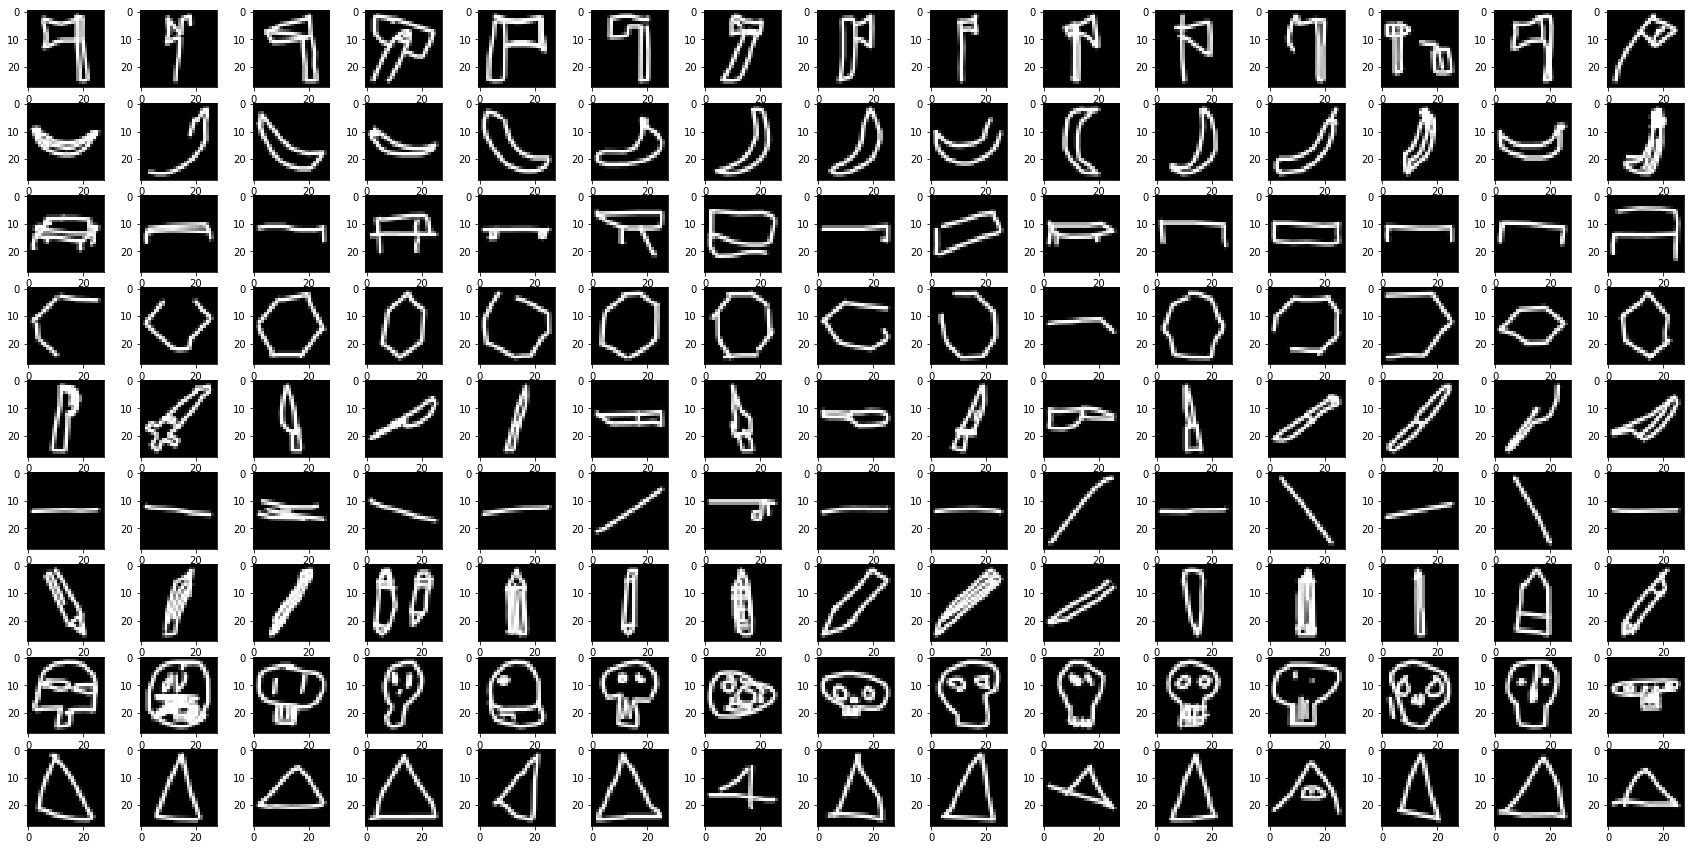

In [6]:
fig, axe = plt.subplots(NUM_CLASSES,15,figsize=(30,15))
for i in range(NUM_CLASSES):
    for j in range(15):
        axe[i,j].imshow(data[cate_index[i] + j].reshape((IMG_SIZE,IMG_SIZE)), cmap='gray')

We resize all images from 1 dimension to 2 dimension

In [7]:
data = data.reshape(data.shape[0], IMG_SIZE, IMG_SIZE, 1)

# 5. Model

### 5.1 Model architecture

Construct convolutional network. The architechture mainly consists of convolution layers and fully connected layers:
<p style="text-align: center;">
```
Conv_layer
BN_layer
Conv_layer
BN_layer
MaxPooling_layer
Dropout_layer
Conv_layer
BN_layer
Conv_layer
BN_layer
MaxPooling_layer
Dropout_layer
Dense_layer
Dropout_layer
Dense_layer
```
</p>

The architecture we use is like the [following one](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53):
![conv net](https://cdn-images-1.medium.com/max/1600/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg)
The basic convolution computation:
![conv computation](https://cdn-images-1.medium.com/max/1600/1*MrGSULUtkXc0Ou07QouV8A.gif)



Define the metrics used in training model, top 1 accuracy and top 3 accuracy

In [8]:
def top_1_acc(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred, k=1)
def top_3_acc(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

Construct the network structure

In [9]:
def conv_net(IMG_SIZE):
    '''
    Construct the convolutional nueral network
    '''
    input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='Input_layer')
    # ========conv layer part ====================
    x = Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu', name='Conv_layer1')(input_img)
    x = BatchNormalization(name='BN_layer1')(x)
    x = Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', name='Conv_layer2')(x)
    x = BatchNormalization(name='BN_layer2')(x)
    x = MaxPooling2D(pool_size=(2,2), name='MaxPooling_layer1')(x)
    x = Dropout(0.5, name='Dropout1')(x)
    x = Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', name='Conv_layer3')(x)
    x = BatchNormalization(name='BN_layer3')(x)
    x = Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu', name='Conv_layer4')(x)
    x = BatchNormalization(name='BN_layer4')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='MaxPooling_layer2')(x)
    x = Dropout(0.5, name='Dropout2')(x)
    # ========fully connected layer part ====================
    x = Flatten()(x)
    x = Dense(512, activation = "relu", name='Dense_layer1')(x)
    x = Dropout(0.5, name='Dropout3')(x)
    x = Dense(256, activation = "relu", name='Dense_layer2')(x)
    x = Dropout(0.5, name='Dropout4')(x)
    output = Dense(NUM_CLASSES, activation = "softmax", name='Output_layer')(x)
    model = Model(input_img, output)
#     Use Adam as the optimizing method, categorical_crossentropy as loss function, top1 and top3 accuracy as the metrics
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=[top_1_acc, top_3_acc])
    return model

###  5.2Train and evaluate model


k-fold cross validation is used to train and validate the convolution network, [the normal k-fold cross validation is like](https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/):
![normal k fold cross validation](https://www.analyticsvidhya.com/wp-content/uploads/2015/11/22.png)
We use stratified k-fold in this project. The process of stratified 5-fold validation for binary classes is shown in the following image:
![Stratified 5-fold cross validation](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2015/11/skfold-768x530.png)

The model architecture:

In [16]:
example_model = conv_net(IMG_SIZE)
plot_model(example_model, to_file='model.png')
example_model.summary()
del example_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_layer1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
BN_layer1 (BatchNormalizatio (None, 28, 28, 16)        64        
_________________________________________________________________
Conv_layer2 (Conv2D)         (None, 28, 28, 32)        12832     
_________________________________________________________________
BN_layer2 (BatchNormalizatio (None, 28, 28, 32)        128       
_________________________________________________________________
MaxPooling_layer1 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 14, 14, 32)        0         
__________

using 5-fold cross validation

In [10]:
EPOCH = 10
BATCH_SIZE = 1024
model_res = []
early_stopping =EarlyStopping(monitor='val_loss', patience=2) # if metric we use doesn't improve in the later 2 rounds, then stop training
# shuffle data and split dataset into 5 folds according to each category,
# which ensures that each category in each fold stays the same proportion as that in the original dataset.
k_fold = StratifiedKFold(n_splits=K, random_state=RANDOM_STATE, shuffle=True)
for i, (train_index, val_index) in enumerate(k_fold.split(data, label)):
    print('==================fold {}==============='.format(i + 1))
    train_x, train_y = data[train_index], label[train_index]
    val_x, val_y = data[val_index], label[val_index]
    model = conv_net(IMG_SIZE)
    res = model.fit(train_x, train_y,
                     validation_data=(val_x, val_y),
                     epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True,
                     callbacks=[early_stopping])

    model_res.append(res)

==================fold 1===============
Train on 1112587 samples, validate on 278151 samples
Epoch 1/10
1112587/1112587 [==============================] - 163s 147us/step - loss: 0.4079 - top_1_acc: 0.8789 - top_3_acc: 0.9598 - val_loss: 0.2141 - val_top_1_acc: 0.9373 - val_top_3_acc: 0.9802
Epoch 2/10
1112587/1112587 [==============================] - 155s 139us/step - loss: 0.2473 - top_1_acc: 0.9281 - top_3_acc: 0.9761 - val_loss: 0.1887 - val_top_1_acc: 0.9439 - val_top_3_acc: 0.9823
Epoch 3/10
1112587/1112587 [==============================] - 160s 143us/step - loss: 0.2180 - top_1_acc: 0.9370 - top_3_acc: 0.9783 - val_loss: 0.1729 - val_top_1_acc: 0.9489 - val_top_3_acc: 0.9832
Epoch 4/10
1112587/1112587 [==============================] - 161s 145us/step - loss: 0.2029 - top_1_acc: 0.9416 - top_3_acc: 0.9800 - val_loss: 0.1705 - val_top_1_acc: 0.9503 - val_top_3_acc: 0.9844
Epoch 5/10
1112587/1112587 [==============================] - 161s 145us/step - loss: 0.1928 - top_1_acc: 0

Visulize the loss and top1 accuracy in training and validation set in fold 1

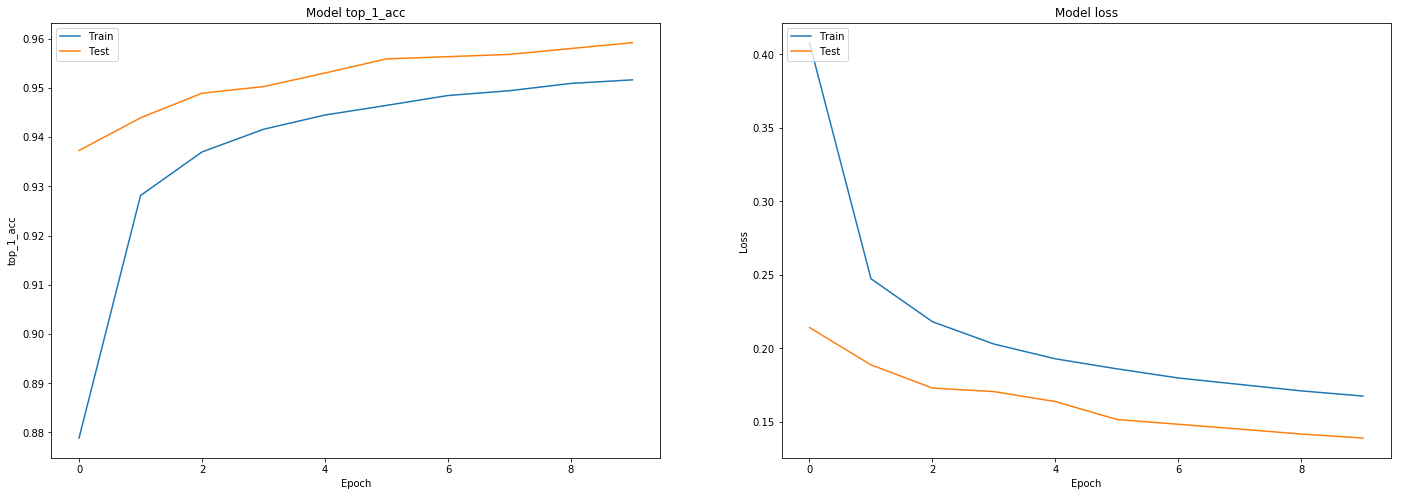

In [17]:
fig, axe = plt.subplots(1,2, figsize=(24,8))
history = model_res[0]
# Plot training & validation accuracy values
axe[0].plot(history.history['top_1_acc'])
axe[0].plot(history.history['val_top_1_acc'])
axe[0].set_title('Model top_1_acc')
axe[0].set_ylabel('top_1_acc')
axe[0].set_xlabel('Epoch')
axe[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
axe[1].plot(history.history['loss'])
axe[1].plot(history.history['val_loss'])
axe[1].set_title('Model loss')
axe[1].set_ylabel('Loss')
axe[1].set_xlabel('Epoch')
axe[1].legend(['Train', 'Test'], loc='upper left')